In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import *

# Change name of dataframe
changes = pd.DataFrame()

In [75]:
ticker = 'AAPL'
start_date = '2019-06-02'
end_date = '2023-06-02'
interval = '1d'

# Get data
data = get_data(ticker, start_date, end_date, interval)

[*********************100%***********************]  1 of 1 completed


In [76]:
# Get returns
data = get_returns(data)
data = data.fillna(0)

In [77]:
# This fuction will get the list of the 10 prior days
window_slide_df = get_list_of_days(data)

In [78]:
data.reset_index(inplace=True)

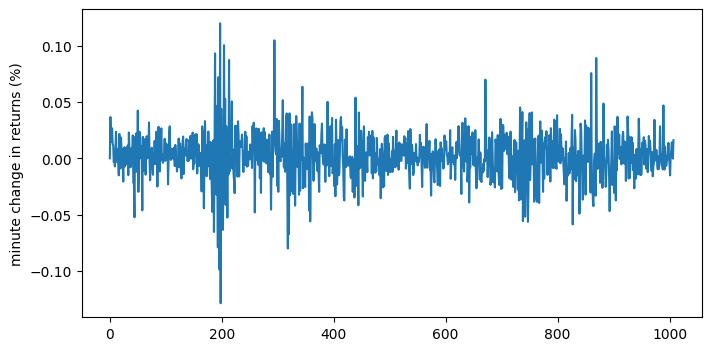

In [79]:
import warnings
warnings.filterwarnings("ignore")

with warnings.catch_warnings():
    data['returns'].plot(figsize=(8, 4))
    plt.ylabel("minute change in returns (%)")

In [72]:
import arviz as az
import numpy as np
import pymc3 as pm
import scipy as sp

with pm.Model() as Apple_model:
    change_returns = pm.Data("changes", data['returns'], export_index_as_coords=True)
    sigma = pm.Exponential('sigma', .05, testval=.1)
    mu = pm.Normal('mu', 0, sd=5, testval=.1)
    
    nu = pm.Exponential('nu', mu)
    logs = pm.GaussianRandomWalk('logs', tau=sigma**-2)
    
    #lam uses variance in pymc3, not sd like in scipy
    r = pm.StudentT('r', nu=nu, mu = mu, lam=1/pm.math.exp(-2*logs), observed=change_returns.get_value())

with Apple_model:
    start = pm.find_MAP(vars=[logs])

with Apple_model:
    step = pm.NUTS(vars=[logs, mu, nu,sigma],scaling=start, gamma=.25)
    start2 = pm.sample(100, step, start=start)[-1]
    
    # Start next run at the last sampled position.
    step = pm.NUTS(vars=[logs, mu, nu,sigma],scaling=start2, gamma=.55)
    trace = pm.sample(1008, step, start=start2)

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{:int64:}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{:int64:}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot 

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{:int64:}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{:int64:}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{:int64:}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot constr

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7137672125395776, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{:int64:}.0
WARNING (theano.tensor.opt): Cannot construct

Sampling 4 chains for 1_000 tune and 1_008 draw iterations (4_000 + 4_032 draws total) took 12 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'logs'}>,
        <Axes: title={'center': 'logs'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

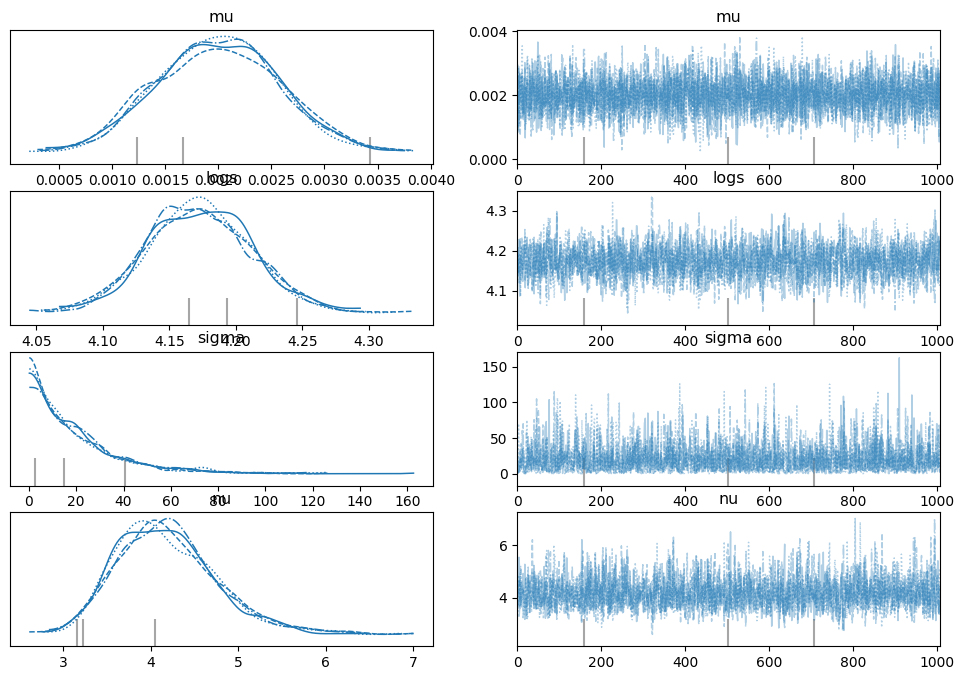

In [73]:
pm.traceplot(trace)

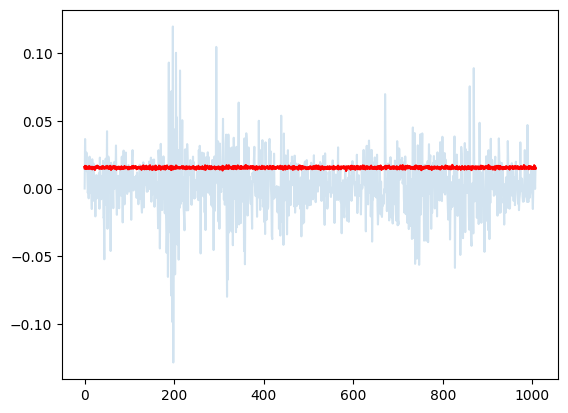

In [74]:
a = trace["logs", ::4].shape[0]

plt.plot(change_returns.get_value(), alpha=.2)
for k in range(4):
    plt.plot(1/np.exp(trace['logs', k::4]),color='r',alpha=1)
ax = plt.gca()

